In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist

import ot

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

dataset = pd.read_csv("D:\\Sentiment Analysis\\IMDB Dataset.csv")

In [2]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
y = (dataset.sentiment=='positive').astype(int).values

In [4]:
review_list = dataset.review.values

tokenized_sentences = [simple_preprocess(review) for review in review_list]

In [5]:
vec_size=100

model = Word2Vec(sentences=tokenized_sentences, vector_size=vec_size, window=5, min_count=1, workers=4)

In [6]:
embedded_reviews = []
for tokens in tokenized_sentences:
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    embedded_reviews.append(np.array(vectors))

In [7]:
Z = np.array([a.shape[0] for a in embedded_reviews])

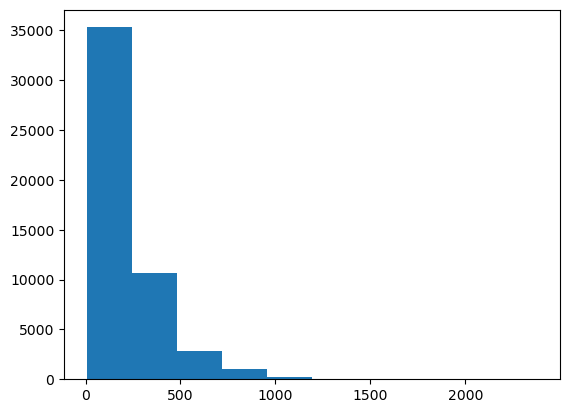

In [8]:
import matplotlib.pyplot as plt

plt.hist(Z)
plt.show()

In [9]:
cdist(embedded_reviews[0], embedded_reviews[0])

array([[ 0.        , 18.74707758, 14.62190189, ..., 24.9434166 ,
        16.08570566, 18.27259437],
       [18.74707758,  0.        , 13.61509844, ..., 24.32998254,
        12.34918013, 18.83887863],
       [14.62190189, 13.61509844,  0.        , ..., 23.07417533,
        12.25443544, 16.44335538],
       ...,
       [24.9434166 , 24.32998254, 23.07417533, ...,  0.        ,
        22.65965707, 26.44036207],
       [16.08570566, 12.34918013, 12.25443544, ..., 22.65965707,
         0.        , 14.26067359],
       [18.27259437, 18.83887863, 16.44335538, ..., 26.44036207,
        14.26067359,  0.        ]])

In [10]:
num_supports = 250

barycenter = np.random.randn(num_supports, vec_size)

In [11]:
a = np.ones(num_supports)/num_supports

# N=len(embedded_reviews)

# for update in range(10):
    
#     Tx=np.zeros_like(barycenter)
    
#     for counter, embedded_review in enumerate(embedded_reviews):

#         m = embedded_review.shape[0]
#         b = np.ones(m)/m

#         M = cdist(barycenter, embedded_review)
        
#         gamma = ot.emd(a,b,M)
        
#         Tx += (1/N)*np.diag(1/a)@gamma@embedded_review
        
#     barycenter=Tx
#     print(update, end = ' ')

barycenter = np.load("estimated_barycenter.npy")


In [12]:
Tx_list=[]

for embedded_review in embedded_reviews:

    m = embedded_review.shape[0]
    b = np.ones(m)/m

    M = cdist(barycenter, embedded_review)

    gamma = ot.emd(a,b,M)

    Tx_list.append((np.diag(1/a)@gamma@embedded_review).flatten())

TX = np.array(Tx_list)

In [13]:
TX.shape

(50000, 25000)

In [14]:
y.shape

(50000,)

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

mdl = SVC()


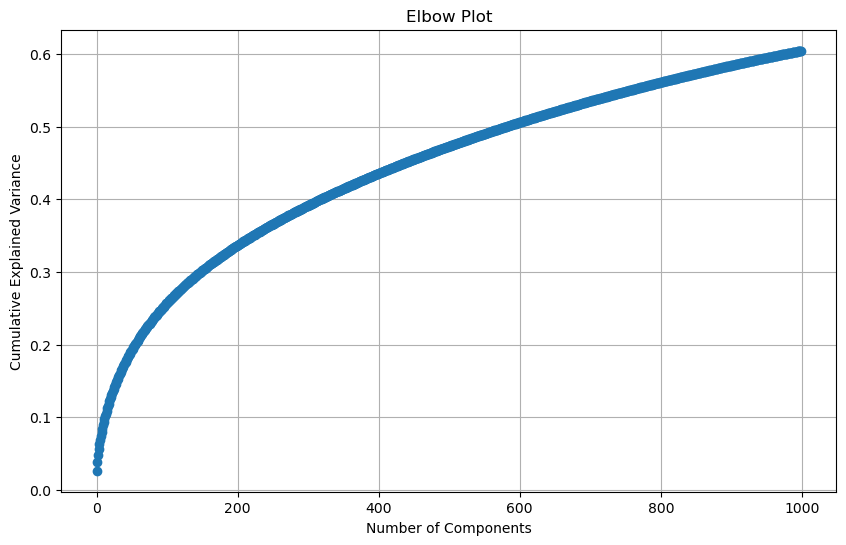

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sample_size = 10000  # Adjust according to your memory capacity
indices = np.random.choice(TX.shape[0], sample_size, replace=False)
TX_sample = TX[indices]
y_sample = y[indices]

# Standardize and perform PCA on the sample
scaler = StandardScaler()
TX_sample_scaled = scaler.fit_transform(TX_sample)

pca = PCA(n_components=1000)
TX_sample_pca = pca.fit_transform(TX_sample_scaled)

# Step 3: Explained variance
explained_variance = pca.explained_variance_ratio_

# Step 4: Create the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Plot')
plt.grid(True)
plt.show()

In [17]:
acc = cross_val_score(mdl,TX_sample_pca,y_sample,cv=10)
acc

array([0.843, 0.856, 0.836, 0.857, 0.854, 0.862, 0.86 , 0.868, 0.859,
       0.861])

In [18]:
np.mean(acc)

0.8556000000000001

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()

acc = cross_val_score(rf,TX_sample_pca,y_sample,cv=10)
acc

array([0.7  , 0.675, 0.708, 0.671, 0.721, 0.734, 0.667, 0.715, 0.709,
       0.714])

In [20]:
np.mean(acc)

0.7013999999999999

In [22]:
TX_sample_pca_full = pca.transform(TX)

In [23]:
TX_sample_pca_full.shape

(50000, 1000)

In [24]:
y.shape

(50000,)

In [25]:
acc = cross_val_score(mdl,TX_sample_pca_full,y,cv=10)
acc

array([0.8738, 0.8774, 0.8736, 0.8678, 0.8662, 0.8748, 0.8676, 0.8616,
       0.8664, 0.8646])

In [26]:
np.mean(acc)

0.8693799999999999